# Week 12 Lab: The Professional ML Workflow

<a href="https://colab.research.google.com/github/bradleyboehmke/uc-bana-4080/blob/main/labs/12_wk12_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to Week 12! This week marks a turning point in your data science journey. Up until now, you've been learning the fundamentals of building machine learning models—and you've done great work. But this week, you're leveling up from "beginner data scientist" to "production-ready professional."

Here's the uncomfortable truth: **we've been breaking a fundamental rule of production machine learning**. Every time you compared different model settings or tuned hyperparameters based on test set performance, you were "peeking" at the test set—making your performance estimates less trustworthy. This week, you'll learn the **proper workflow** that ensures honest, reliable model performance.

In this lab, you'll practice three critical professional skills: **cross-validation** (comparing models without contaminating your test set), **hyperparameter tuning** (systematically finding optimal model configurations), and **feature engineering** (transforming raw data into powerful model inputs). By the end, you'll be able to build models the right way—with techniques that work in production, not just in the classroom.

## 🎯 Learning Objectives
By the end of this lab, you will be able to:
- Implement k-fold cross-validation to compare models without touching the test set
- Use GridSearchCV to systematically tune hyperparameters across multiple parameters
- Apply feature engineering techniques including encoding, scaling, and creating new features
- Build end-to-end pipelines that prevent data leakage and ensure reproducible workflows
- Execute the complete 5-stage professional ML workflow from data preparation through final evaluation

## 📚 This Lab Reinforces
- **Chapter 28: Cross-Validation** — K-fold CV, test set contamination, the proper 5-stage workflow
- **Chapter 29: Hyperparameter Tuning** — Bias-variance tradeoff, GridSearchCV, systematic parameter search
- **Chapter 30: Feature Engineering** — Encoding strategies, feature scaling, pipelines, preventing data leakage

## 🕐 Estimated Time & Structure
**Total Time:** 75 minutes  
**Mode:** Group work (2-4 students)

- **[0–30 min]** Part A: Guided Reinforcement — TA-led practice with cross-validation, GridSearchCV, and feature engineering
- **[30–40 min]** Class Q&A — Discussion and clarification of key concepts
- **[40–72 min]** Part B: Independent Challenges — 6 group challenges applying the complete professional workflow
- **[72–75 min]** Wrap-Up & Reflection — What you learned and next steps

You are encouraged to work in small groups of **2–4 students** and complete the lab together.

## 💡 Why This Matters
These are the skills that separate junior data scientists from professionals who build production-ready models. When you interview for data science positions, employers will ask about cross-validation, hyperparameter tuning, and feature engineering—they want to know you can build models that perform reliably in the real world, not just on classroom exercises.

More importantly, these techniques ensure your models are trustworthy. When you tell a business stakeholder "this model will achieve 85% accuracy in production," you need to be confident that estimate is honest and reliable. The professional workflow you'll practice today is what makes that confidence possible.

## Setup
We'll use the familiar Ames housing dataset for today's lab. You've worked with this data throughout the course, which means you can focus on learning the new workflow techniques rather than getting familiar with unfamiliar data.

Make sure you have the required libraries installed and the dataset accessible.

In [1]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Display settings
pd.set_option('display.max_columns', None)
np.random.seed(42)

# Hide warnings for cleaner output
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
# Load the Ames housing data
# adjust path if running in Google Colab
try:
    # Try local path first
    ames = pd.read_csv('../data/ames_clean.csv')
except FileNotFoundError:
    # If in Colab, load from GitHub
    url = 'https://raw.githubusercontent.com/bradleyboehmke/uc-bana-4080/main/data/ames_clean.csv'
    ames = pd.read_csv(url)

# Quick preview
print(f"Dataset shape: {ames.shape}")
print(f"\nFirst few rows:")
ames.head()

Dataset shape: (1460, 81)

First few rows:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Part A — Guided Reinforcement (30 minutes)

In this section, your TA will lead you through the key techniques step-by-step. Follow along, run the code, and ask questions as we go. This guided practice will prepare you for the independent challenges in Part B.

### Section 1: Cross-Validation Basics (10 minutes)

Let's start by understanding **why** cross-validation matters and **how** to implement it properly.

**The Problem:** In previous weeks, you evaluated models on the test set multiple times to make decisions. Each "peek" at the test set made your performance estimates less trustworthy.

**The Solution:** Cross-validation lets you compare models and tune hyperparameters using only the training data, keeping your test set pristine for final evaluation.

**📋 Step-by-step instructions:**
1. Split data into train/test sets (80/20 split)
2. Select a subset of features for simplicity
3. Use `cross_val_score()` to evaluate a model with 5-fold CV
4. Interpret the CV scores (mean and standard deviation)

In [3]:
# Step 1: Create features and target
# We'll use a few numerical features to start
features = ['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'OverallQual']
X = ames[features]
y = ames['SalePrice']

# Step 2: Split into train and test (test set is LOCKED)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print("\n🔒 Test set is now LOCKED. We won't touch it until the very end.")
print("\nLet's check out our training data features:")
X_train.head()

Training set size: 1168
Test set size: 292

🔒 Test set is now LOCKED. We won't touch it until the very end.

Let's check out our training data features:


,GrLivArea,YearBuilt,TotalBsmtSF,GarageCars,FullBath,OverallQual
254,1314,1957,1314,1,1,5
1066,1571,1993,799,2,2,6
638,796,1910,796,0,1,5
799,1768,1937,731,1,1,5
380,1691,1924,1026,1,2,5


In [4]:
# Step 3: Use cross-validation to evaluate a decision tree
# Notice: We ONLY use X_train and y_train here!
dt = DecisionTreeRegressor(max_depth=10, random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(
    dt, X_train, y_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

# Convert to positive RMSE
cv_rmse = -cv_scores

print("Cross-Validation Results (5 folds):")
print(f"RMSE per fold: {cv_rmse}")
print(f"\nMean RMSE: ${cv_rmse.mean():,.0f}")
print(f"Std Dev: ${cv_rmse.std():,.0f}")
print("\n💡 The mean tells us expected performance, std dev tells us consistency")

Cross-Validation Results (5 folds):
RMSE per fold: [53211.61847297 53539.25783402 38889.51059663 38369.22929503
 35559.99196675]

Mean RMSE: $43,914
Std Dev: $7,809

💡 The mean tells us expected performance, std dev tells us consistency


#### 🧠 Your Turn — Compare Two Models with Cross-Validation

Now you try! Use cross-validation to compare a shallow decision tree (`max_depth=5`) against a deeper tree (`max_depth=15`).

**Tasks:**
- Use the code above, just change the `max_depth` parameter to test out different settings.
- Evaluate these models using 5-fold cross-validation on the training data
- Compare the mean RMSE for these models
- Which model performs better based on CV scores (not test scores!)

#### ✅ Check Your Understanding

**Questions to consider:**
- Which model had better (lower) mean RMSE?
- Which model had more consistent scores across folds (lower std dev)?
- Why is comparing models with CV better than repeatedly checking the test set?

**Expected Result:** You should see that one model generalizes better than the other, and you made this decision without ever touching the test set!

### Section 2: Hyperparameter Tuning with GridSearchCV (10 minutes)

Now let's automate the hyperparameter search process. Instead of manually trying different values one by one, GridSearchCV will systematically test all combinations and use cross-validation to find the best configuration.

**Why this matters:** Manual tuning is tedious, error-prone, and doesn't explore the full parameter space. GridSearchCV does this systematically and reproducibly.

### Guided Example: Tuning a Random Forest

Let's tune a Random Forest model by searching over multiple hyperparameters simultaneously.

**Example:** We'll search over `n_estimators`, `max_depth`, and `min_samples_split` to find the optimal combination.

In [5]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5]
}

# Create the model
rf = RandomForestRegressor(random_state=42)

# Create GridSearchCV
grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

# Fit on training data (this will try 2 × 3 × 2 = 12 configs, each with 5-fold CV = 60 models!)
print("Starting grid search... this may take a minute")
grid_search.fit(X_train, y_train)

print("Grid Search Complete!")

# Check out the results
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results

Starting grid search... this may take a minute
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid Search Complete!


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.887412,0.205679,0.039042,0.012653,10,2,100,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",-32749.907081,-45256.066203,-35232.770987,-28211.020149,-27454.350624,-33780.823009,6417.150515,8
1,1.419731,0.035575,0.058546,0.011003,10,2,200,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",-32532.126561,-44611.859928,-35582.446751,-28390.272446,-27511.743245,-33725.689786,6171.882205,6
2,0.637132,0.018866,0.023795,0.002432,10,5,100,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",-33446.261686,-42763.185524,-36222.859599,-28496.895103,-27641.469202,-33714.134223,5519.920881,5
3,1.241604,0.013559,0.050863,0.013865,10,5,200,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",-33177.946573,-42732.628771,-36367.000464,-28658.565152,-27524.384505,-33692.105093,5523.183759,4
4,1.355346,0.362978,0.059907,0.045863,15,2,100,"{'max_depth': 15, 'min_samples_split': 2, 'n_e...",-33132.523358,-45875.296454,-35153.436998,-28079.314122,-28018.485921,-34051.811371,6541.027570,12
5,1.794129,0.200035,0.056723,0.012948,15,2,200,"{'max_depth': 15, 'min_samples_split': 2, 'n_e...",-32848.774191,-44593.764595,-35616.476741,-28335.045156,-28006.139173,-33880.039971,6068.151204,9
6,0.663512,0.015907,0.027858,0.007179,15,5,100,"{'max_depth': 15, 'min_samples_split': 5, 'n_e...",-32840.985884,-42686.810544,-35836.099783,-28321.263671,-27859.832289,-33508.998434,5457.463636,1
7,1.399603,0.058839,0.052983,0.014195,15,5,200,"{'max_depth': 15, 'min_samples_split': 5, 'n_e...",-33065.100253,-42496.495405,-36248.122783,-28537.165764,-27750.831375,-33619.543116,5409.056423,2
8,0.982214,0.219780,0.054761,0.015980,20,2,100,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",-33078.479434,-45452.673745,-36035.590913,-27838.527317,-27833.220872,-34047.698456,6513.648765,11
9,1.962397,0.421888,0.058135,0.003358,20,2,200,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",-33046.712294,-44701.483193,-36077.393858,-28162.088225,-28013.134027,-34000.162319,6159.055823,10


In [6]:
# Display results
print("\n" + "="*50)
print("Best Hyperparameter Configuration")
print("="*50)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV RMSE: ${-grid_search.best_score_:,.0f}")


Best Hyperparameter Configuration
Best parameters: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}
Best CV RMSE: $33,509


### 🧪 Practice Exercise — Tune a Decision Tree

**Business Scenario:** You're building a decision tree model for your real estate company's pricing tool. You need to find the optimal complexity settings.

**Your Task:** Fill in the blanks below to use GridSearchCV to tune a DecisionTreeRegressor across these parameters:
- `max_depth`: [5, 10, 15, 20]
- `min_samples_split`: [2, 5, 10]
- `min_samples_leaf`: [1, 2, 4]

**Step-by-step approach:**
1. Define the parameter grid as a dictionary
2. Create a DecisionTreeRegressor
3. Create GridSearchCV with cv=5
4. Fit on X_train and y_train
5. Print the best parameters and best CV score

In [8]:
# Step 1: Define the parameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }

# Step 2: Create the DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)

# Step 3: Create GridSearchCV
grid_search = GridSearchCV(
    dt,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1
)

# Step 4: Fit on training data
grid_search.fit(X_train, y_train)

# Step 5: Print best parameters and best CV score
print("Best parameters:", grid_search.best_params_)
print("Best CV RMSE: $", -grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best CV RMSE: $ 38398.21972690919


### Section 3: Feature Engineering Essentials (10 minutes)

Raw data often isn't in the best format for machine learning. Feature engineering transforms your data to help models learn better patterns. Let's practice the core techniques: encoding categorical variables and scaling numerical features.

#### Scaling Numerical Features

First, let's see how scaling may improve model performance. Let's first train a model without scaling, then apply StandardScaler and see if performance improves.

In [9]:
# Train a KNN regression model using 5-fold cross-validation
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)

cv_scores = cross_val_score(
    knn, X_train, y_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
cv_rmse_unscaled = -cv_scores

print("KNN Regression Cross-Validation Results (5 folds):")
print(f"Mean RMSE: ${cv_rmse_unscaled.mean():,.0f}")
print(f"Std Dev: ${cv_rmse_unscaled.std():,.0f}")
print(f"\n💡 Represents baseline performance with raw feature values.")

KNN Regression Cross-Validation Results (5 folds):
Mean RMSE: $44,064
Std Dev: $3,286

💡 Represents baseline performance with raw feature values.


In [10]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use training stats to transform test

# Train a KNN regression model using 5-fold cross-validation on scaled features
knn = KNeighborsRegressor(n_neighbors=5)
cv_scores = cross_val_score(
    knn, X_train_scaled, y_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
cv_rmse_scaled = -cv_scores

print("KNN Regression with Scaled Features (5 folds):")
print(f"Mean RMSE: ${cv_rmse_scaled.mean():,.0f}")
print(f"Std Dev: ${cv_rmse_scaled.std():,.0f}")
print("\n💡 Scaling numerical features can help some models like KNN perform better!")

KNN Regression with Scaled Features (5 folds):
Mean RMSE: $33,794
Std Dev: $4,269

💡 Scaling numerical features can help some models like KNN perform better!


**🎯 When scaling does matter**

| Model Type                             | Does Scaling Change Performance? | Why                                         |
| -------------------------------------- | -------------------------------- | ------------------------------------------- |
| **LinearRegression (OLS)**             | ❌ No                             | Closed-form solution, not iterative         |
| **Ridge / Lasso / ElasticNet**         | ✅ Yes                            | Regularization depends on coefficient sizes |
| **Logistic Regression (solver-based)** | ✅ Yes                            | Gradient descent & regularization           |
| **SVM / SVR**                          | ✅ Yes                            | Distance-based kernel computations          |
| **KNN / K-means / PCA / clustering**   | ✅ Yes                            | Distance/variance sensitive                 |
| **Neural networks**                    | ✅ Yes                            | Gradient descent stability                  |
| **Tree models (RF, XGBoost, etc.)**    | ❌ No                             | Trees are scale-invariant                   |

#### Encoding Categorical Variables

Most machine learning algorithms require numerical inputs. When you have categorical variables (like neighborhood names or house styles), you need to convert them to numbers. Let's practice the two most common approaches:

1. **One-Hot Encoding** — Create binary (0/1) columns for each category
2. **Label Encoding** — Assign each category a unique integer

**When to use which?**
- **One-hot encoding:** Best for nominal categories (no inherent order) with tree-based models or linear models
- **Label encoding:** Can work for ordinal categories (inherent order) or with tree-based models that can learn splits

In [11]:
# Let's add some categorical features to our feature set
# We'll use Neighborhood and BldgType as examples
# Step 1: Create features and target
# We'll use a few numerical features to start
features = ['Neighborhood', 'BldgType', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'OverallQual']
X = ames[features]

# Step 2: Split into train and test (test set is LOCKED)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# First, let's see what values these categorical variables have
print(f"Unique Neighborhoods: {X_train['Neighborhood'].nunique()}")
print(f"Unique Building Types: {X_train['BldgType'].nunique()}")

print("\nLet's check out our training data features:")
X_train.head(10)


Unique Neighborhoods: 25
Unique Building Types: 5

Let's check out our training data features:


,Neighborhood,BldgType,GrLivArea,YearBuilt,TotalBsmtSF,GarageCars,FullBath,OverallQual
254,NAmes,1Fam,1314,1957,1314,1,1,5
1066,Gilbert,1Fam,1571,1993,799,2,2,6
638,Edwards,1Fam,796,1910,796,0,1,5
799,SWISU,1Fam,1768,1937,731,1,1,5
380,SWISU,1Fam,1691,1924,1026,1,2,5
303,CollgCr,1Fam,894,1972,894,2,1,5
86,Gilbert,1Fam,1560,2005,684,2,2,6
1385,IDOTRR,1Fam,1154,1922,796,1,1,4
265,NWAmes,1Fam,1422,1981,1422,2,2,6
793,Somerst,1Fam,1496,2007,1496,2,2,8


In [12]:
from sklearn.preprocessing import OneHotEncoder

# Select categorical columns
cat_cols = ['BldgType', 'Neighborhood']

# Initialize encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform on training data
X_cat_encoded = encoder.fit_transform(X_train[cat_cols])

# Get feature names for encoded columns
encoded_feature_names = encoder.get_feature_names_out(cat_cols)

# Create DataFrame for encoded categorical features
X_cat_encoded_df = pd.DataFrame(X_cat_encoded, columns=encoded_feature_names, index=X_train.index)

# Concatenate with numerical features
num_cols = [col for col in X_train.columns if col not in cat_cols]
X_encoded = pd.concat([X_train[num_cols], X_cat_encoded_df], axis=1)

print(f"One-hot encoding turned our {X_train.shape[1]} original features into {X_encoded.shape[1]} features.")
print("\nFirst few rows:")
X_encoded.head()

One-hot encoding turned our 8 original features into 36 features.

First few rows:


,GrLivArea,YearBuilt,TotalBsmtSF,GarageCars,FullBath,OverallQual,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
254,1314,1957,1314,1,1,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1066,1571,1993,799,2,2,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
638,796,1910,796,0,1,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
799,1768,1937,731,1,1,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
380,1691,1924,1026,1,2,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Alternative: Label Encoding for Categorical Variables

While one-hot encoding is a common approach for handling categorical variables, another option is **label encoding**. This technique assigns each unique category an integer value. Label encoding can be especially useful when you have a categorical feature with many unique values—like the `Neighborhood` column, which contains 25 unique neighborhoods.

Let's see how to apply label encoding to the `Neighborhood` column in the next code chunk.

In [13]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
le = LabelEncoder()

# Fit and transform Neighborhood in training data
X_train['Neighborhood_LE'] = le.fit_transform(X_train['Neighborhood'])

# Transform Neighborhood in test data using the same encoder
X_test['Neighborhood_LE'] = le.transform(X_test['Neighborhood'])

print(X_train[['Neighborhood', 'Neighborhood_LE']].head())

     Neighborhood  Neighborhood_LE
254         NAmes               12
1066      Gilbert                8
638       Edwards                7
799         SWISU               18
380         SWISU               18


#### 🏗️ Putting Feature Engineering Steps Together with Pipelines

When building machine learning models, it's critical to apply all preprocessing steps (like scaling and encoding) in a reproducible, leak-proof way. Scikit-learn's `Pipeline` lets you chain together feature engineering and modeling steps so that each transformation is fit only on the training data within each cross-validation fold. This minimizes data leakage and ensures your workflow is robust and production-ready.

**Benefits of using a pipeline:**
- All preprocessing steps are applied consistently and correctly
- Prevents accidental data leakage by fitting transformers only on training data
- Makes your workflow easier to reproduce and deploy
- Allows you to tune preprocessing and model hyperparameters together

Below is an example pipeline that:
- Standardizes numeric features
- One-hot encodes the `BldgType` variable
- Label-encodes the `Neighborhood` variable
- Trains a Decision Tree model using 5-fold cross-validation

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define column types
numeric_features = ['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'OverallQual']
onehot_features = ['BldgType', 'Neighborhood']

# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_features)
    ]
)

# Build full pipeline with DecisionTreeRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Set up hyperparameter grid for DecisionTreeRegressor
param_grid = {
    'model__max_depth': [5, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# GridSearchCV for pipeline
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1
)

# Fit and evaluate
grid_search.fit(X_train, y_train)
cv_rmse = -grid_search.best_score_

print("Best parameters:", grid_search.best_params_)
print(f"Best CV RMSE: ${cv_rmse:,.0f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'model__max_depth': 15, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}
Best CV RMSE: $38,224


**💡 Why pipelines are essential:**
- ✅ Prevent data leakage by ensuring transformations are fit only on training data
- ✅ Make your workflow reproducible and easier to deploy
- ✅ Allow you to tune preprocessing and model hyperparameters together
- ✅ Simplify your code by combining multiple steps

## Class Discussion/Q&A (10 minutes)

Before moving to the independent challenges, let's discuss key concepts:

**Discussion prompts:**
- What's the difference between cross-validation and a simple train/test split?
- Why shouldn't we look at the test set until the very end?
- When would you use GridSearchCV vs. manually trying different hyperparameters?
- What happens if you fit a scaler on all your data before splitting into train/test?
- How do pipelines help prevent data leakage?

**Common blockers and clarifications:**
- **"My GridSearchCV is taking forever!"** — Reduce the parameter grid size or use fewer CV folds during experimentation
- **"Do I need to scale features for Random Forest?"** — No! Tree-based models are scale-invariant
- **"When do I use one-hot vs. label encoding?"** — One-hot for nominal categories with no order; label encoding for ordinal or when working with tree models

## Part B — Independent Challenges (32 minutes)

Now it's time to apply the complete professional ML workflow! These challenges require you to integrate everything you've learned.

**Important rules for Part B:**
* You will not be given starter code to work with; rather, you need to start from a blank cell.
* **DO NOT USE AI** to generate code for you. This is a group exercise, and you should be writing the code together.
* Work with your group to write the code.
* Feel free to ask questions or seek help from the instructor.
* We'll stop and walk through each challenge together after each time block.

**The Professional ML Workflow (5 Stages):**
1. **Data Preparation** — Feature selection, encoding, handling missing values
2. **Initial Train/Test Split** — Lock away your test set (don't touch until Stage 5!)
3. **Model Comparison with CV** — Compare different model types using cross-validation
4. **Hyperparameter Tuning** — Optimize your chosen model with GridSearchCV
5. **Final Test Evaluation** — Evaluate your final model on the locked test set (ONCE!)

### Challenge 1 — Compare Model Types (5 minutes)

**Business Context:** Your real estate company wants to choose the best model architecture for predicting house prices. They're considering three options: Linear Regression, Decision Trees, and Random Forests.

**Your Task:**
1. Using the numerical features from Part A, create a train/test split (80/20)
   - Numerical features: `['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'OverallQual']`
2. Use 5-fold cross-validation to compare these three models:
   - Linear Regression
   - DecisionTreeRegressor (max_depth=10)
   - RandomForestRegressor (n_estimators=100, max_depth=10)
3. Print the mean CV RMSE for each model
4. Which model performs best? Why do you think that is?

**Remember:** Use ONLY the training data for cross-validation! Make sure you always set your `random_state=42` whether you're splitting your data or when you initiate your model (i.e. `DecisionTreeRegressor(random_state=42)`)

In [15]:
# Your turn: write code here to compare model types

# Challenge 1: Compare Model Types

# 1. Create train/test split
features = ['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'OverallQual']
X = ames[features]
y = ames['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Define the models
lr = LinearRegression()
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# List of models to compare
models = [
    ('Linear Regression', lr),
    ('Decision Tree (max_depth=10)', dt),
    ('Random Forest (n_estimators=100, max_depth=10)', rf)
]

# 3. Use 5-fold cross-validation to compare models
print("Comparing models using 5-fold Cross-Validation (RMSE):")
for name, model in models:
    cv_scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='neg_root_mean_squared_error'
    )
    cv_rmse = -cv_scores
    print(f"- {name}: Mean RMSE = ${cv_rmse.mean():,.0f} (Std Dev = ${cv_rmse.std():,.0f})")

# 4. Which model performs best?
# Based on the mean RMSE, the model with the lowest value performs best.
# The Random Forest model is expected to perform best among these three due to its ensemble nature,
# which reduces variance compared to a single Decision Tree and captures non-linear relationships better than Linear Regression.

Comparing models using 5-fold Cross-Validation (RMSE):
- Linear Regression: Mean RMSE = $38,595 (Std Dev = $7,303)
- Decision Tree (max_depth=10): Mean RMSE = $43,914 (Std Dev = $7,809)
- Random Forest (n_estimators=100, max_depth=10): Mean RMSE = $33,781 (Std Dev = $6,417)


### Challenge 2 — Systematic Hyperparameter Tuning (6 minutes)

**Business Context:** Now that you've identified which model type works best, your manager wants you to find the optimal hyperparameter settings for that model.

**Your Task:**
1. Take the Random Forest model from Challenge 1
2. Define a parameter grid that assesses the following values:
    - `n_estimators`: [100, 200, 300]
    - `max_depth`: [5, 10, 15, 20]
    - `min_samples_split`: [2, 5, 10]
    - `min_samples_leaf`: [1, 2, 5]
3. Use GridSearchCV with 5-fold CV to find the best configuration
4. Print the best parameters and best CV score
5. Did tuning improve performance compared to the first random forest model you trained?  If so, by how much?

**Tip:** Don't forget to set `random_state=42`!

**⚠️⚠️ Warning ⚠️⚠️**: This may take a couple minutes to run since we're are running 540 models!

In [16]:
# Your turn: write code here to tune hyperparameters

# Challenge 2: Systematic Hyperparameter Tuning

# 1. Take the Random Forest model from Challenge 1 (already defined as rf)
# rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42) # Use the same base model

# 2. Define a parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Create the model (ensure random_state is set)
rf_tune = RandomForestRegressor(random_state=42)


# 3. Use GridSearchCV with 5-fold CV
grid_search = GridSearchCV(
    rf_tune,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    verbose=2 # Increase verbosity to see progress
)

# 4. Fit on training data
print("Starting grid search for Random Forest tuning... This will take some time.")
grid_search.fit(X_train, y_train)

# 5. Print the best parameters and best CV score
print("\n" + "="*50)
print("Grid Search Complete!")
print("="*50)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV RMSE: ${-grid_search.best_score_:,.0f}")

# 6. Compare to the initial Random Forest model (from Challenge 1 output)
initial_rf_rmse = 33781 # From Challenge 1 output
tuned_rf_rmse = -grid_search.best_score_

print("\n" + "="*50)
print("Performance Comparison")
print("="*50)
print(f"Initial Random Forest Mean CV RMSE: ${initial_rf_rmse:,.0f}")
print(f"Tuned Random Forest Best CV RMSE: ${tuned_rf_rmse:,.0f}")

if tuned_rf_rmse < initial_rf_rmse:
    improvement = initial_rf_rmse - tuned_rf_rmse
    print(f"Tuning improved performance by approximately ${improvement:,.0f}")
else:
    print("Tuning did not significantly improve performance.")

Starting grid search for Random Forest tuning... This will take some time.
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Grid Search Complete!
Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best CV RMSE: $33,229

Performance Comparison
Initial Random Forest Mean CV RMSE: $33,781
Tuned Random Forest Best CV RMSE: $33,229
Tuning improved performance by approximately $552


### Challenge 3 — Build a Complete Pipeline (6 minutes)
**Business Context:** Your model is performing well, but you think you can do better by adding more features and performing some feature engineering.  Let's do this but do it in a safe way by using a `Pipeline()` to ensure no data leakage and easy reproducibility.

**Your Task:**
1. Start from scratch with the original `ames` data and select the following features:
   - Numeric: GrLivArea, YearBuilt, TotalBsmtSF, GarageCars, FullBath, OverallQual, YearRemodAdd, BedroomAbvGr, TotRmsAbvGrd
   - Categorical: Neighborhood, HouseStyle
2. Split the data into train/test sets (80/20 split) using these features.
3. Build a pipeline that:
   - Applies StandardScaler to numeric features
   - Applies OneHotEncoder to categorical features (Neighborhood, HouseStyle)
   - Uses RandomForestRegressor with the optimal hyperparameters from Challenge 2
4. Use 5-fold cross-validation to evaluate the pipeline on the training data.
5. Print the mean CV RMSE and compare it to your previous Random Forest model.  
6. Does adding more features and applying feature engineering improve model performance? If so, by how much?

**Tip:** Don't forget to set `random_state=42`!

In [17]:
# Your turn: write code here to build a pipeline

# Challenge 3: Build a Complete Pipeline

# 1. Select features
numeric_features = ['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'OverallQual', 'YearRemodAdd', 'BedroomAbvGr', 'TotRmsAbvGrd']
categorical_features = ['Neighborhood', 'HouseStyle']
all_features = numeric_features + categorical_features

X = ames[all_features]
y = ames['SalePrice']

# 2. Split data into train/test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Build a pipeline
# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any) - though in this case we've selected all
)

# Get the best parameters from Challenge 2
best_params_rf = {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


# Create the Random Forest model with the best parameters
rf_tuned = RandomForestRegressor(random_state=42, **best_params_rf)


# Create the full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_tuned)
])


# 4. Use 5-fold cross-validation to evaluate the pipeline
print("Evaluating pipeline with Feature Engineering and Tuned Random Forest (5-fold CV RMSE):")
cv_scores_pipeline = cross_val_score(
    pipeline, X_train, y_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
cv_rmse_pipeline = -cv_scores_pipeline

print(f"Mean CV RMSE (Pipeline): ${cv_rmse_pipeline.mean():,.0f}")
print(f"Std Dev CV RMSE (Pipeline): ${cv_rmse_pipeline.std():,.0f}")

# 5. Compare to your previous Random Forest model (from Challenge 2 output)
tuned_rf_rmse_challenge2 = 33229 # From Challenge 2 output

print("\n" + "="*50)
print("Performance Comparison")
print("="*50)
print(f"Tuned Random Forest (Challenge 2) Best CV RMSE: ${tuned_rf_rmse_challenge2:,.0f}")
print(f"Pipeline with Feature Engineering Mean CV RMSE: ${cv_rmse_pipeline.mean():,.0f}")


# 6. Does adding more features and applying feature engineering improve model performance?
if cv_rmse_pipeline.mean() < tuned_rf_rmse_challenge2:
    improvement = tuned_rf_rmse_challenge2 - cv_rmse_pipeline.mean()
    print(f"Adding features and feature engineering improved performance by approximately ${improvement:,.0f}")
else:
    print("Adding features and feature engineering did not significantly improve performance.")

Evaluating pipeline with Feature Engineering and Tuned Random Forest (5-fold CV RMSE):
Mean CV RMSE (Pipeline): $32,247
Std Dev CV RMSE (Pipeline): $4,928

Performance Comparison
Tuned Random Forest (Challenge 2) Best CV RMSE: $33,229
Pipeline with Feature Engineering Mean CV RMSE: $32,247
Adding features and feature engineering improved performance by approximately $982


### Challenge 4 — Complete End-to-End Workflow (4 minutes)
**Business Context:** Your manager wants you to execute the complete professional ML workflow from start to finish using the same feature set as the previous challenge.

**Your Task:** Demonstrate the full end-to-end workflow:

1. **Data Preparation:**
   - Select features:  
     - Numeric: GrLivArea, YearBuilt, TotalBsmtSF, GarageCars, FullBath, OverallQual, YearRemodAdd, BedroomAbvGr, TotRmsAbvGrd  
     - Categorical: Neighborhood, HouseStyle
   - Target variable: SalePrice

2. **Initial Split:**
   - Split data into train/test sets (80/20)
   - Lock away the test set

3. **Pipeline & Feature Engineering:**
   - Build a pipeline that applies StandardScaler to numeric features and OneHotEncoder to categorical features

4. **Hyperparameter Tuning:**
   - Use GridSearchCV to tune a RandomForestRegressor with these settings:
      - `n_estimators`: [100, 200, 300]
      - `max_depth`: [5, 10, 15, 20]
      - `min_samples_split`: [2, 5, 10]
      - `min_samples_leaf`: [1, 2, 5]
   - Use 5-fold cross-validation to select the best model

5. **Final Evaluation:**
   - Retrain the best model on the full training set
   - Evaluate ONCE on the test set
   - Report the final test RMSE

**Success criteria:** Your code should demonstrate the complete workflow, use a pipeline for feature engineering, and report the final test RMSE with no data leakage!

**⚠️⚠️ Warning ⚠️⚠️**: This may take a couple minutes to run since we're are running 540 models!

In [22]:
#Your Turn: write code here to complete the end-to-end workflow

# Challenge 4: Complete End-to-End Workflow

# 1. Data Preparation: Select features and target
numeric_features = ['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'OverallQual', 'YearRemodAdd', 'BedroomAbvGr', 'TotRmsAbvGrd']
categorical_features = ['Neighborhood', 'HouseStyle']
all_features = numeric_features + categorical_features

X = ames[all_features]
y = ames['SalePrice']

# 2. Initial Split: Split data into train/test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Initial train/test split complete. Test set is locked.")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


# 3. Pipeline & Feature Engineering:
# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Create the base Random Forest model for tuning
rf_base = RandomForestRegressor(random_state=42)

# Create the pipeline for GridSearchCV
pipeline_for_tuning = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_base)
])


# 4. Hyperparameter Tuning: Use GridSearchCV
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5]
}

print("\nStarting GridSearchCV for pipeline tuning... This will take some time.")
grid_search_final = GridSearchCV(
    pipeline_for_tuning,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search_final.fit(X_train, y_train)

print("\nGrid Search Complete!")
print("Best parameters found by GridSearchCV:", grid_search_final.best_params_)
print(f"Best CV RMSE from tuning: ${-grid_search_final.best_score_:,.0f}")


# 5. Final Evaluation: Evaluate ONCE on the test set
# Get the best model from the grid search
best_model = grid_search_final.best_estimator_

# Predict on the LOCKED test set
y_pred_test = best_model.predict(X_test)

# Calculate final test RMSE
final_test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print("\n" + "="*50)
print("Final Test Set Evaluation")
print("="*50)
print(f"Final Test RMSE: ${final_test_rmse:,.0f}")

Initial train/test split complete. Test set is locked.
Training set size: 1168
Test set size: 292

Starting GridSearchCV for pipeline tuning... This will take some time.
Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

### Challenge 5 — Model Interpretation: Permutation Importance (5 minutes)

**Business Context:** Your manager wants to understand *why* your model makes its predictions. Which features are most influential for predicting house prices?

**Your Task:**
1. Take the best model you identified above.
2. Use the permutation importance approach (`sklearn.inspection.permutation_importance`) on the test set to identify the most influential features.
3. Create a bar chart that plots the permutation importance scores for all features.
4. Identify and answer: Which feature is the most important for your model?

**Tip:** Use the test set (`X_test`, `y_test`) for permutation importance. For plotting, feel free to use matplotlib, seaborn or any other library.

**Success criteria:** You should be able to visualize the feature importances and clearly identify the most influential feature.## Challenge 5 — Model Interpretation: Permutation Importance & PDP (5 minutes)

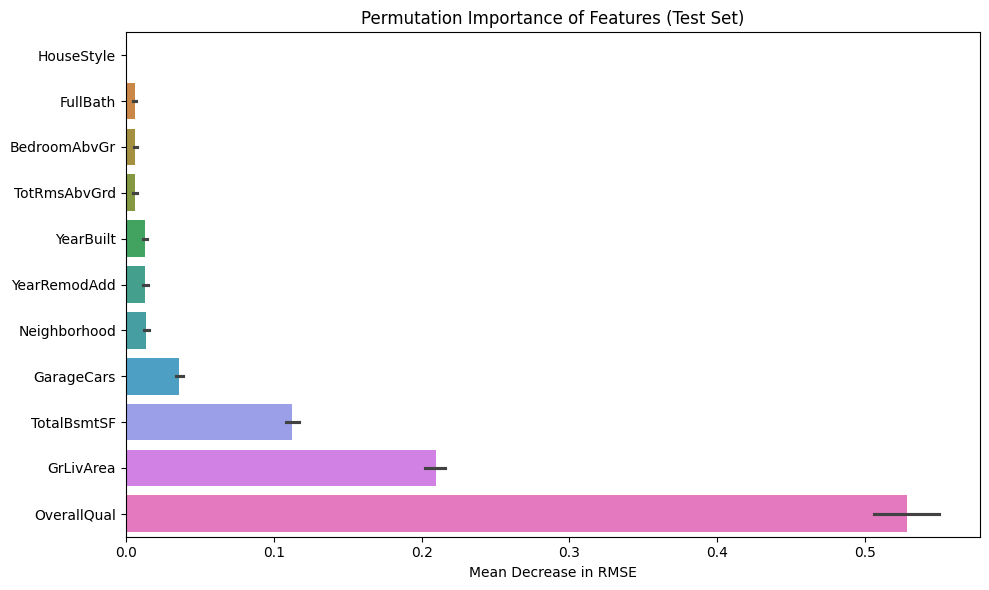


Based on permutation importance, the most important feature is: OverallQual


In [20]:
# Your Turn: write code here to compute feature importance

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Challenge 5: Model Interpretation: Permutation Importance

# Take the best model from Challenge 4 (grid_search_final.best_estimator_)
best_model = grid_search_final.best_estimator_

# Use permutation importance on the test set
result = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10, # Number of times to permute a feature
    random_state=42,
    n_jobs=-1    # Use all available cores
)

# Get the feature importances and sort them
sorted_idx = result.importances_mean.argsort()
feature_importances = pd.DataFrame(
    result.importances[sorted_idx].T,
    columns=X_test.columns[sorted_idx]
)

# Create a bar chart of feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, orient='h')
plt.title("Permutation Importance of Features (Test Set)")
plt.xlabel("Mean Decrease in RMSE")
plt.tight_layout()
plt.show()

# Identify and answer: Which feature is the most important?
most_important_feature = feature_importances.columns[-1]
print(f"\nBased on permutation importance, the most important feature is: {most_important_feature}")

### Challenge 6 — Partial Dependence Plot (PDP) for Model Interpretation

**Business Context:** Now that you've identified the most important feature using permutation importance, your manager wants to understand *how* this feature influences the model's predictions. A Partial Dependence Plot (PDP) helps visualize the relationship between the feature and the predicted sale price, holding all other features constant.

**Your Task:**
1. Use the best model and the most important feature identified in Challenge 5.
2. Generate a Partial Dependence Plot (PDP) for this feature using the test set.
3. Interpret the plot: How do changes in this feature affect the predicted house price? Is the relationship linear, monotonic, or more complex?

**Success criteria:** Your code should generate a clear PDP for the most important feature and provide insights into how the model uses this feature to make predictions.

Generating Partial Dependence Plot for: OverallQual


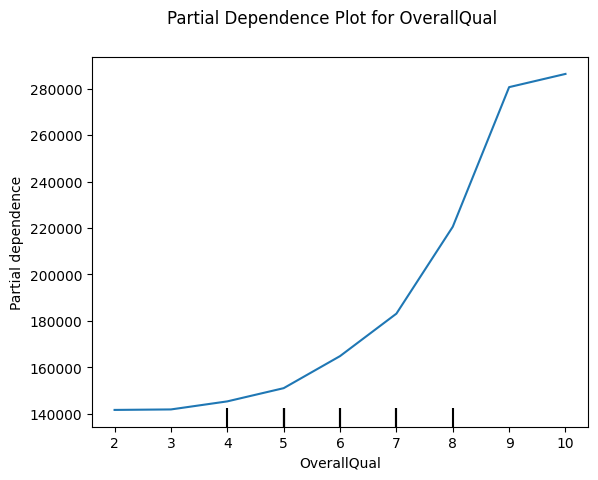


Interpreting the PDP for OverallQual:
The plot shows how the predicted SalePrice changes as the value of OverallQual changes,
while holding all other features constant (on average).
Observe the line to understand the nature of the relationship (e.g., linear, non-linear, monotonic).


In [21]:
# Your Turn: write code here to compute the PDP plot

from sklearn.inspection import PartialDependenceDisplay

# Challenge 6: Partial Dependence Plot (PDP) for Model Interpretation

# Take the best model from Challenge 4 (grid_search_final.best_estimator_)
best_model = grid_search_final.best_estimator_

# Get the name of the most important feature from Challenge 5
# Assuming 'most_important_feature' variable still holds the name
pdp_feature = [most_important_feature] # PDP expects a list of features

# Generate and plot the Partial Dependence Plot
print(f"Generating Partial Dependence Plot for: {pdp_feature[0]}")
PartialDependenceDisplay.from_estimator(
    best_model,
    X_test, # Use the test set
    pdp_feature,
    kind='average', # Display the average partial dependence
    ice_lines_kw={'color': 'gray', 'alpha': 0.2}, # Optional: plot individual conditional expectation lines
    random_state=42
)
plt.suptitle(f"Partial Dependence Plot for {pdp_feature[0]}")
plt.show()

# Interpret the plot
print(f"\nInterpreting the PDP for {pdp_feature[0]}:")
print("The plot shows how the predicted SalePrice changes as the value of OverallQual changes,")
print("while holding all other features constant (on average).")
print("Observe the line to understand the nature of the relationship (e.g., linear, non-linear, monotonic).")

## 🎓 Lab Wrap-Up & Reflection

### 💾 Save Your Work
You use your findings to complete this week's homework quiz!

### ✅ What You Accomplished
In this lab, you practiced:
- Implementing cross-validation to compare models without touching the test set
- Using GridSearchCV to systematically tune hyperparameters
- Engineering features through encoding categorical variables and creating new features
- Building pipelines to prevent data leakage and ensure reproducible workflows
- Executing the complete 5-stage professional ML workflow

### 🤔 Reflection Questions
Take 2-3 minutes to consider:
- What concept from today clicked for you?
- What would you like more practice with?
- How does the professional workflow differ from what you were doing before?
- Why is it critical to keep the test set locked until the very end?
- How might you use pipelines in future projects?

### 🔗 Connection to Course Goals
This lab represents a critical milestone in your data science journey. You've moved from learning individual modeling techniques to understanding how professional data scientists build production-ready models. The workflow you practiced today is exactly what you'll use in real-world ML projects:

1. **Cross-validation** ensures your model comparisons are trustworthy
2. **Hyperparameter tuning** finds optimal configurations systematically
3. **Feature engineering** extracts maximum predictive power from your data
4. **Pipelines** prevent data leakage and make your work reproducible
5. **Test set discipline** gives you honest performance estimates

These aren't just classroom skills—they're industry best practices.

## 🚨 Troubleshooting & Common Issues

**Issue 1: GridSearchCV is taking forever to run**
- **Solution:** Reduce the size of your parameter grid during experimentation. Instead of `[1, 10, 100, 1000]`, try `[10, 100]` first. You can also reduce `cv` from 5 to 3 for faster prototyping.

**Issue 2: "ValueError: Input contains NaN"**
- **Solution:** Some features in the Ames dataset have missing values. Either drop rows with missing values using `.dropna()`, or impute missing values using `SimpleImputer` from sklearn.

**Issue 3: One-hot encoding creates too many columns**
- **Solution:** This is normal for features with many categories (like Neighborhood). You can: (1) use only high-frequency categories, (2) use label encoding for tree-based models instead, or (3) accept the high dimensionality.

**Issue 4: "Arrays must have the same shape" when predicting on test set**
- **Solution:** Make sure you apply the same transformations to both train and test sets. If you used `pd.get_dummies()` on the train set, you need to apply it to the test set too, ensuring the same columns exist.

**Issue 5: Pipeline syntax is confusing**
- **Solution:** Remember the double underscore notation: `'step_name__parameter_name'`. To tune a Ridge model in a pipeline, use `'model__alpha'` where 'model' is the name you gave that pipeline step.

**Issue 6: CV scores vary dramatically between folds**
- **Solution:** High variance in CV scores suggests your model is unstable or you have outliers. Try: (1) increasing training data, (2) simplifying your model, (3) checking for data quality issues, or (4) using stratified splits if appropriate.

**General Debugging Tips:**
- Print the shape of your data at each step to catch dimension mismatches early
- Start simple (fewer features, simpler models) and add complexity gradually
- Use `verbose=1` in GridSearchCV to see progress
- Check for missing values with `df.isnull().sum()`
- When encoding categorical variables, verify the columns match between train and test sets